In [1]:
'''
Author: Ivan Gvozdanovic
Date: 10/02/2024
Description:
    GAE A2C algorithm for preforming Redistricting.

    The A2C.py file has all the functionality that you need for RL to work. The current policy Neural Network is very specific to the problems 
    i used to work on (it has a mask which hides some outputs of the network). When you use it in your problem, call the Policy class instead of 
    TransformerPolicy class. Policy class is a neural network which produces a probabilty distribution over the action space and then
    pick a random sample from that distribution. Over time the policy converges to the optimal distribution from which you can pick the actions
    with highest probabilty as your optimal action, given the current state.

    The HEART of the algorithm is the function ***run_n_step_with_gae*** inside A2C.py. This function runs the whole algorithm and schedules the 
    periodical training. It uses the collected rewards along a Markov chain trajectory using current policy \pi_{\theta} and after N steps, it 
    computes the Advantages of these rewards (google it if you need more details but its a simple idea). 

    You need to define the environment class which only has the ***reset*** function to reset the problem to initial state and 
    ***step*** function which applies the action to the current state, computes the reward and returns the next state and the reward. Look into the
    RedistrictingENV.py file. 


    
''';

In [2]:
'''
Good reading material: 

    https://github.com/tsmatz/reinforcement-learning-tutorials/blob/master/03-actor-critic.ipynb
    https://github.com/Lucasc-99/Actor-Critic/blob/master/src/a2c.py
    https://github.com/pytorch/examples/blob/main/reinforcement_learning/actor_critic.py
    https://github.com/Francesco-Sovrano/Framework-for-Actor-Critic-deep-reinforcement-learning-algorithms
    https://github.com/tensorflow/docs/blob/master/site/en/tutorials/reinforcement_learning/actor_critic.ipynb
    
    https://www.reddit.com/r/reinforcementlearning/comments/aux7a5/question_about_nstep_learning_with_dqn/
    https://datascience.stackexchange.com/questions/46245/off-policy-n-step-learning-with-dqn/46260#46260
    https://people.cs.umass.edu/~barto/courses/cs687/Chapter%207.pdf
    https://arxiv.org/pdf/1606.02647
    https://arxiv.org/abs/1901.07510
''';

In [3]:
'''
 

''';

In [78]:
import numpy as np
import os
import networkx as nx
import itertools
from collections import deque
import time as Time
import torch
from collections import namedtuple, defaultdict
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

from RedistrictingENV import PolytopeENV as Env 



from gerrychain import (Partition, Graph, MarkovChain,
                        updaters, constraints, accept, metagraph)
from gerrychain.proposals import recom
from gerrychain.constraints import contiguous
from functools import partial


In [79]:
from reward_functions import reward_cost, calculate_reward1, calculate_reward2, calculate_reward3

In [87]:

# '''This cell is not important, its problem specific.'''

# from helper_functions import create_fiber_sampling_erdos_renyi_graph, \
#                              extract_distance_matrix, \
#                              create_real_data_graph, \
#                              create_real_data_initial_sol,\
#                              moving_average, \
#                              create_state_graph, \
#                              permute_moves,\
#                              group_keys_by_value



# initial_states = {} # dictionary holding the initial states.
# patches = 1
# node_num = 10
# p = 0.8
# graph_num = 1

# #Pick the file to the problem:
# file = 'A2C_Redistricting_'


# graph = Graph.from_json('C:/Users/gvozd/Desktop/University/Research/Code/Combinatorial RL/Redistricting using RL/data/gerrymandria.json')

# " Produce an initial solution"
# my_updaters = {
#     "population": updaters.Tally("TOTPOP", alias='population'),
#     "cut_edges": updaters.cut_edges
# }

# initial_partition = Partition(
#     graph,
#     assignment="district",
#     updaters=my_updaters
# )


# single_flips = metagraph.all_valid_flips(initial_partition, constraints=[contiguous])
# reward = constraints.validity.deviation_from_ideal(partition=initial_partition)
# #print("Reward: ", reward)
# print(initial_partition.parts)
# single_flips_list = list(single_flips)
# single_flips_list = sorted(single_flips_list, key=lambda x: (list(x.values())[0], list(x.keys())[0]))
# print(len(single_flips_list), single_flips_list)
# print(group_keys_by_value(single_flips_list))

# print("###################################")

# new_partition = initial_partition.flip({8: '1'})
# # new_partition = new_partition.flip({23: '2'})
# print(new_partition.parts)
# reward = constraints.validity.deviation_from_ideal(partition=new_partition)
# #print(reward)
# single_flips = metagraph.all_valid_flips(new_partition, constraints=[contiguous])
# single_flips_list = list(single_flips)
# single_flips_list = sorted(single_flips_list, key=lambda x: (list(x.values())[0], list(x.keys())[0]))
# print(len(single_flips_list), single_flips_list)
# print(group_keys_by_value(single_flips_list))

# print("###################################")


# # new_partition = new_partition.flip({55: '8'})
# # print(new_partition.parts)
# # reward = constraints.validity.deviation_from_ideal(partition=new_partition)
# # #print(reward)
# # single_flips = metagraph.all_valid_flips(new_partition, constraints=[contiguous])
# # single_flips_list = list(single_flips)
# # single_flips_list = sorted(single_flips_list, key=lambda x: (list(x.values())[0], list(x.keys())[0]))
# # print(len(single_flips_list), single_flips_list)





# # available_actions, initial_states = create_fiber_sampling_erdos_renyi_graph(file, initial_states, node_num, p, graph_num)
# # initial_states, available_actions, node_num = create_real_data_graph(path_initial) # works for smaller problems where we can compute lattice.


# # # print(available_actions)
# # print(initial_states)
# # for m in range(len(available_actions)):
# #     if m < 76:
# #         print(available_actions[m])


In [86]:
save_data = True  # save Q table data and cost vector data.
save_plots = False  # save the plots
save_data_rate = 20

# Example usage for running episodes
num_episodes = 300 # how many epusodes you want to run
max_path_length = 100 # length of each episodes in terms of steps


n_step = max_path_length # how often to train the networks. 
sheduler_lr_update = 10 # every 10 trainig periods we modify the step size
gamma = 0.9 # discount factor of the maximization objective
lam = 0.5 # lambda parameter for Generalized Advantage Estimator
discount_factor = gamma



# Neural network learning rates.
actor_lr = 0.0003
critic_lr = 0.0003
step_size = num_episodes//sheduler_lr_update
lr_actor_gamma = (0.00001/actor_lr)**(1/sheduler_lr_update)
lr_critic_gamma = (0.00001/critic_lr)**(1/sheduler_lr_update)
print(step_size)
print(lr_actor_gamma)
print(lr_critic_gamma)


# Lower and upper bounds on actions (coefficients in my case)
lb = -1
ub = 2


# mask_size = 5
# mask_rate = 50
# mask_action_size = [len(available_actions)//mask_size for i in range(mask_size)]
# mask_action_size[-1] += len(available_actions)%mask_size # add the remained if not divisible.
# mask_range = mask_action_size[0]
# print(mask_action_size)
# action_space_values = [ [i+lb for i in range(ub-lb)] for j in range(len(available_actions)) ]
# action_space_size = [ub-lb for i in range(len(available_actions))]
# print(len(action_space_size))


30
0.7116851017915987
0.7116851017915987


In [8]:
'''
DEFINE THE POLICY ARCHITECTURE AND INITIALIZE IT
'''

from A2C import Policy, \
                TransformerPolicy, \
                select_action, \
                select_action_transformer, \
                run_n_step_with_gae, \
                select_best_action, \
                select_best_action_transformer, \
                freeze_parameters, \
                generate_mask

feature_net_arch = [len(initial_states[0]), 56, 28, 12, 28]
# model = Policy(feature_net_arch, len(initial_states[0]), len(action_space_values))
model = TransformerPolicy(len(initial_states[0]), action_space_size, mask_action_size, mask_rate)
print(model)

optimizer = torch.optim.Adam([
    {'params': model.transformer_encoder.parameters()},   # Shared feature extractor
    {'params': model.action_heads.parameters(), 'lr': actor_lr},  # Actor-specific parameters
    {'params': model.value_head.parameters(), 'lr': critic_lr} # Critic-specific parameters
])

scheduler_actor = StepLR(optimizer, step_size=step_size, gamma=lr_actor_gamma)
scheduler_critic = StepLR(optimizer, step_size=step_size, gamma=lr_critic_gamma)


# actor_params = list(model.action_head.parameters()) + list(model.feature_net.parameters())  # Actor network params
# critic_params = list(model.value_head.parameters())  # Critic network params
# actor_optimizer = torch.optim.Adam(actor_params, lr=actor_lr)  # Learning rate for actor
# critic_optimizer = torch.optim.Adam(critic_params, lr=critic_lr)  # Learning rate for critic
eps = np.finfo(np.float32).eps.item()
SavedAction = namedtuple('SavedAction', ['log_probs', 'value', 'probs', 'mask_log_probs'])

TransformerPolicy(
  (embedding): Linear(in_features=253, out_features=16, bias=True)
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
        )
        (linear1): Linear(in_features=16, out_features=16, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=16, out_features=16, bias=True)
        (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLin

In [9]:
'''DEFINE THE ENVIRONMENT AND INITIALIZE'''


# Convert dictionary values to a list of arrays
visited_states = [np.array(initial_states[0])]
visited_states = np.stack(visited_states)

#Initialize the environment.
env = Env(initial_states, # initial_state
         num_episodes, # total_episodes
         50, # show_path_num
         visited_states,  # visited_states
         available_actions, # basis_moves
         node_num, # node_num
         0, # P
         lb, #lb
         )



<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


In [10]:
'''RUN THE ALGORITHM'''


cumm_running_reward = 0
episode_reward_list = []
cumm_running_reward_list = []
loss_list = []
actor_lr_list = []
critic_lr_list = []
robins_monro_condition = []


start_time = Time.time()
iteration = 0


# run infinitely many episodes
for i_episode in range(num_episodes):

    # reset environment and episode reward
    state = env.reset()
    ep_reward = 0

    # for each episode, only run 9999 steps so that we don't
    # infinite loop while learning
    for t in range(max_path_length):

        

        # select action from policy
        action = select_action(model, state, SavedAction, action_space_values, False)
        
        # take the action and return the reward and next state
        state, reward, done, _ = env.step(action)

        # record the rewards and train the agent if the scheduler says so.
        model.rewards.append(reward)
        ep_reward += (discount_factor**t)*reward
        cumm_running_reward += reward
        cumm_running_reward_list.append(reward)
        
        # perform backprop of both actor and critic neural networks.
        actor_lr,critic_lr = run_n_step_with_gae(model, n_step, gamma, lam, optimizer, scheduler_actor, scheduler_critic, done)
        if actor_lr != None and critic_lr != None:
            actor_lr_list.append(actor_lr)
            critic_lr_list.append(critic_lr)
            robins_monro_condition.append(actor_lr/critic_lr)
        if done:
            break
        
        iteration += 1
        
    if (i_episode + 1) % save_data_rate == 0:
        torch.save(model.state_dict(), 'Models/policy_model_Node#_' + str(node_num) + "_EP_" + str(num_episodes) +  '.pth')
        end_time = Time.time()
        print(f'It took {(end_time-start_time)/60} minutes to run {i_episode} episodes.')
        
    episode_reward_list.append(ep_reward)
    
torch.save(model.state_dict(), 'Models/policy_model_Node#_' + str(node_num) + "_EP_" + str(num_episodes) +  '.pth')


end_time = Time.time()
print(f'It took {(end_time-start_time)/60} minutes to run {num_episodes} episodes.')

Episode: 1 ||| Reward: -854.3282615251301 ||| Discovered States: 1


C:\Users\gvozd\anaconda3\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 2 ||| Reward: -810.6204121121621 ||| Discovered States: 1
Action is a zero vector! Action coeffs: 
Episode: 3 ||| Reward: -894.5707587407725 ||| Discovered States: 1
Episode: 4 ||| Reward: -908.3312613082081 ||| Discovered States: 1
Episode: 5 ||| Reward: -881.2739785649935 ||| Discovered States: 1
Episode: 6 ||| Reward: -837.033001075134 ||| Discovered States: 1
Action is a zero vector! Action coeffs: 
Episode: 7 ||| Reward: -876.0605316057296 ||| Discovered States: 1
Episode: 8 ||| Reward: -858.6688467030776 ||| Discovered States: 1
Episode: 9 ||| Reward: -817.6432201568931 ||| Discovered States: 1
Episode: 10 ||| Reward: -861.4053395602434 ||| Discovered States: 1
Action is a zero vector! Action coeffs: 
Episode: 11 ||| Reward: -948.4152060021956 ||| Discovered States: 1
Episode: 12 ||| Reward: -877.5485584477593 ||| Discovered States: 1
Episode: 13 ||| Reward: -853.5364185066527 ||| Discovered States: 1
Episode: 14 ||| Reward: -862.8878466803455 ||| Discovered States: 1
Ac

Action is a zero vector! Action coeffs: 
Episode: 97 ||| Reward: -874.0536071392046 ||| Discovered States: 3
Episode: 98 ||| Reward: -858.7681296495333 ||| Discovered States: 3
Episode: 99 ||| Reward: -782.622603819739 ||| Discovered States: 3
Episode: 100 ||| Reward: -849.0397291915008 ||| Discovered States: 3
It took 31.305642100175223 minutes to run 99 episodes.
Episode: 101 ||| Reward: -816.4783070629042 ||| Discovered States: 3
Episode: 102 ||| Reward: -864.3061806128349 ||| Discovered States: 3
Episode: 103 ||| Reward: -861.0796170451449 ||| Discovered States: 3
Episode: 104 ||| Reward: -832.7874286439413 ||| Discovered States: 3
Action is a zero vector! Action coeffs: 
Episode: 105 ||| Reward: -873.6461297933572 ||| Discovered States: 3
Episode: 106 ||| Reward: -899.0004656054631 ||| Discovered States: 3
Episode: 107 ||| Reward: -820.6014492057255 ||| Discovered States: 3
Episode: 108 ||| Reward: -906.5899095745494 ||| Discovered States: 3
Action is a zero vector! Action coeffs:

Episode: 196 ||| Reward: -864.2463759765018 ||| Discovered States: 6
Episode: 197 ||| Reward: -853.9969384906773 ||| Discovered States: 6
Episode: 198 ||| Reward: -794.0752691795366 ||| Discovered States: 6
Episode: 199 ||| Reward: -824.0199498129341 ||| Discovered States: 6
Episode: 200 ||| Reward: -896.0993577603626 ||| Discovered States: 6
It took 67.50215571721395 minutes to run 199 episodes.
Episode: 201 ||| Reward: -852.1409384977133 ||| Discovered States: 6
Action is a zero vector! Action coeffs: 
Episode: 202 ||| Reward: -834.2878229264757 ||| Discovered States: 6
Episode: 203 ||| Reward: -783.4040084031158 ||| Discovered States: 6
Episode: 204 ||| Reward: -855.8362762459387 ||| Discovered States: 6
Episode: 205 ||| Reward: -869.3311733370394 ||| Discovered States: 6
Episode: 206 ||| Reward: -814.6537353513631 ||| Discovered States: 6
Episode: 207 ||| Reward: -874.2839731875918 ||| Discovered States: 6
Episode: 208 ||| Reward: -891.7544963780218 ||| Discovered States: 6
Episode

Episode: 296 ||| Reward: -852.8127101876743 ||| Discovered States: 9
Episode: 297 ||| Reward: -895.493552569383 ||| Discovered States: 9
Episode: 298 ||| Reward: -911.2935106967033 ||| Discovered States: 9
Episode: 299 ||| Reward: -913.474509073108 ||| Discovered States: 9
Action is a zero vector! Action coeffs: 
Episode: 300 ||| Reward: -825.5314032597819 ||| Discovered States: 9
It took 97.19343442519506 minutes to run 299 episodes.
It took 97.19380019108455 minutes to run 300 episodes.


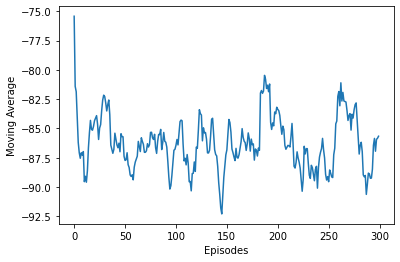

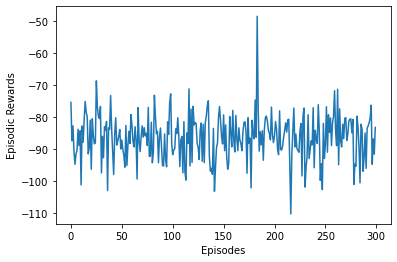

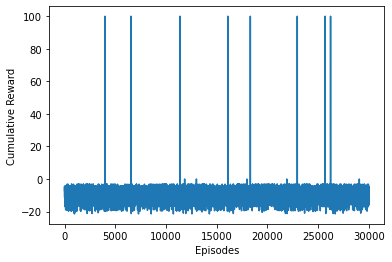

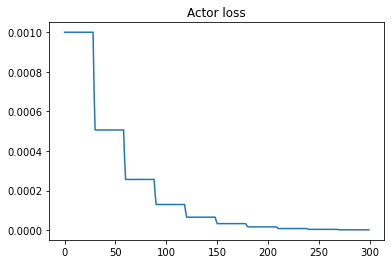

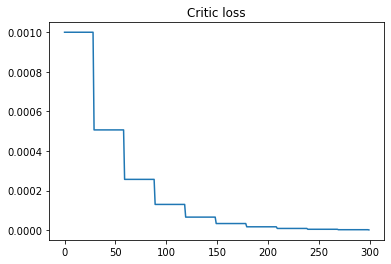

In [11]:
cum_reward_x_axis = [i for i in range(len(cumm_running_reward_list))]
ep_reward_x_axis = [i for i in range(len(episode_reward_list))]
loss_x_axis = [i for i in range(len(loss_list))]
actor_lr_x_axis = [i for i in range(len(actor_lr_list))]
critic_lr_x_axis = [i for i in range(len(critic_lr_list))]

smoothed_rewards = moving_average(episode_reward_list, 10)
smoothed_rewards_x_axis = [i for i in range(len(smoothed_rewards))]

plt.plot(smoothed_rewards_x_axis, smoothed_rewards)
plt.xlabel("Episodes")
plt.ylabel("Moving Average")
plt.show()

plt.plot(ep_reward_x_axis, episode_reward_list)
plt.xlabel("Episodes")
plt.ylabel("Episodic Rewards")
plt.show()
plt.plot(cum_reward_x_axis, cumm_running_reward_list)
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")
plt.show()
plt.plot(actor_lr_x_axis, actor_lr_list)
plt.title("Actor loss")
plt.show()
plt.plot(critic_lr_x_axis, critic_lr_list)
plt.title("Critic loss")
plt.show()


In [13]:
# Load the model 
feature_net_arch = [len(initial_states[0]), 56, 28, 12, 28]
# model = Policy(feature_net_arch, len(initial_states[0]), len(action_space_values))
model = TransformerPolicy(len(initial_states[0]), action_space_size, mask_action_size, mask_rate)
model.load_state_dict(torch.load('Models/policy_model_Node#_' + str(node_num) + "_EP_" + str(num_episodes) +  '.pth')) #+ str(node_num)
model.eval()



min_rewards = []
sim_number = 1
optimum_reached = 0
max_path_length = 1000

for sim in range(sim_number):

    print("########################################################################")
    print("########################################################################")
    print("########################################################################")
    print("########################################################################")
    print("########################################################################")
    
    # Convert dictionary values to a list of arrays
    visited_states = [np.array(initial_states[0])]
    visited_states = np.stack(visited_states)

    #Initialize the environment.
    env = Env(initial_states, # initial_state
             num_episodes, # total_episodes
             50, # show_path_num
             visited_states,  # visited_states
             available_actions, # basis_moves
             node_num, # node_num
             0, # P
             lb, #lb
             )


    
    
    # reset environment and episode reward
    state = env.reset()
 


    # for each episode, only run 9999 steps so that we don't
    # infinite loop while learning
    for t in range(max_path_length):

#         action = select_best_action_transformer(model, state, action_space_values, t, mask_range)
        action = select_action_transformer(model, state, SavedAction, action_space_values, mask_range, t, False)

        # take the action
        next_state, reward, done, _ = env.step(action)

        if done == True:
            feasibility_violation += 1

        model.rewards.append(reward)
        ep_reward += reward
        
        action_rounded = np.array(np.round(action), dtype=int)
        all_actions = [np.multiply(action_rounded[i], available_actions[i]) for i in range(len(action_rounded))]
        all_actions = np.stack(all_actions)
        full_action = np.sum(all_actions, 0)
        
        print("State: \n", state)
        print("Action: ", action)
        print("Add state+action: \n", np.add(state, full_action))
        print("Training reward: ", reward)
        print("Next State: \n", next_state)
        
        
        state = next_state


########################################################################
########################################################################
########################################################################
########################################################################
########################################################################


TypeError: select_action_transformer() missing 1 required positional argument: 'testing'

In [ ]:
#227 episodes == 16 states found. 

In [ ]:
nodes = [i for i in range(2263)]
permuted_moves = permute_moves(nodes, discovered_moves_list, node_number)